In [11]:
cd ..

/afs/inf.ed.ac.uk/user/s13/s1320903/Neuroglycerin/neukrill-net-work


In [17]:
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics
import pickle
import neukrill_net.utils
import neukrill_net.encoding as enc
import neukrill_net.taxonomy as t

The holoviews.ipython extension is already loaded. To reload it, use:
  %reload_ext holoviews.ipython


In [46]:
settings = neukrill_net.utils.Settings("settings.json")
run_settings = neukrill_net.utils.load_run_settings('run_settings/experiment_setting_colnorms_higher_aug.json', 
            settings, force=True)
model = pylearn2.utils.serial.load(run_settings['pickle abspath'])

In [47]:
# format the YAML
yaml_string = neukrill_net.utils.format_yaml(run_settings, settings)
# load proxied objects
proxied = pylearn2.config.yaml_parse.load(yaml_string, instantiate=False)
# pull out proxied dataset
proxdata = proxied.keywords['dataset']
# force loading of dataset and switch to test dataset
proxdata.keywords['force'] = True
proxdata.keywords['training_set_mode'] = 'test'
proxdata.keywords['verbose'] = False
# then instantiate the dataset
dataset = pylearn2.config.yaml_parse._instantiate(proxdata)

In [48]:
if hasattr(dataset.X, 'shape'):
    N_examples = dataset.X.shape[0]
else:
    N_examples = len(dataset.X)
batch_size = 500
while N_examples%batch_size != 0:
    batch_size += 1
n_batches = int(N_examples/batch_size)
#n_classes = len(settings.classes)

In [49]:
model.set_batch_size(batch_size)
X = model.get_input_space().make_batch_theano()
Y = model.fprop(X)
if type(X) == tuple:
    f = theano.function(X,Y)
else:
    f = theano.function([X],Y)

In [50]:
augment = 1
y = np.zeros((N_examples*augment,188))
# get the data specs from the cost function using the model
pcost = proxied.keywords['algorithm'].keywords['cost']
cost = pylearn2.config.yaml_parse._instantiate(pcost)
data_specs = cost.get_data_specs(model)
i = 0

In [51]:
for _ in range(augment):
    # make sequential iterator
    iterator = dataset.iterator(batch_size=batch_size,num_batches=n_batches,
                        mode='even_sequential', data_specs=data_specs)
    for batch in iterator:
        if type(X) == tuple:
            y[i*batch_size:(i+1)*batch_size,:] = f(batch[0],batch[1])
        else:
            y[i*batch_size:(i+1)*batch_size,:] = f(batch[0])
        i += 1

In [52]:
af = run_settings.get("augmentation_factor",1)
if af > 1:
    y_collapsed = np.zeros((int(N_examples/af), 188)) 
    for i,(low,high) in enumerate(zip(range(0,dataset.y.shape[0],af),
                                range(af,dataset.y.shape[0]+af,af))):
        y_collapsed[i,:] = np.mean(y[low:high,:], axis=0)
    y = y_collapsed
    # and collapse labels
    labels = dataset.y[range(0,dataset.y.shape[0],af)]
elif augment > 1:
    y_collapsed = np.zeros((N_examples,188))
    # different kind of augmentation, has to be collapsed differently
    for row in range(N_examples):
        y_collapsed[row,:] = np.mean(np.vstack([r for r in 
            y[[i for i in range(row,N_examples*augment,N_examples)],:]]), 
            axis=0)
    y = y_collapsed            
    labels = dataset.y
else:
    labels = dataset.y

In [53]:
y.shape

(3089, 188)

In [59]:
predictions = np.zeros(y.shape)
np.copyto(predictions, y)
predictions.shape

(3089, 188)

Predict with the classes.

In [60]:
class_predictions = predictions[:, :121]
labels = labels[:, :121]
logloss = sklearn.metrics.log_loss(labels,class_predictions)
print("Log loss: {0}".format(logloss))

Log loss: 0.935334935387


Now let's try with superclasses.

In [31]:
superclasses = predictions[:,121:(121+38)]
superclasses.shape

(3089, 38)

In [61]:
import neukrill_net.taxonomy as t
only_leaf_children = []
hier = enc.get_hierarchy(settings)

layer = t.TaxonomyLayer(1)

for s in hier[1]:
    flag = True
    for key, values in t.superclasses.items():
        for i, v in enumerate(values):
            if v == s and i != 1:
                flag = False
    if flag:
        if s not in only_leaf_children:
            only_leaf_children.append(s)

In [33]:
import neukrill_net.taxonomy as t
layer = t.TaxonomyLayer(1)

backmap = {}
for i, c in enumerate(settings.classes):
    j = int(np.where(np.array(hier[1]) == layer[c])[0])
    if hier[1][j] in only_leaf_children:
        try:
            backmap[j] += [i]
        except:
            backmap[j] = [i]

In [34]:
class_predictions = predictions[:, 0:121]
nr = class_predictions
weight = 0.01

for index,r in enumerate(superclasses):
    if index%1000 == 0:
        print index
    for i,j in enumerate(r):
        priors = []
        if i in backmap:
            d = sum([settings.class_priors[k] for k in backmap[i]])
            for a in backmap[i]:
                priors.append(settings.class_priors[a]/d)
            nr[index,backmap[i]] = nr[index, backmap[i]]*(1-weight) + (weight)*j*np.array(priors)

0
1000
2000
3000


In [33]:
nr.shape

(3089, 121)

With weight=0 it's the same.

In [18]:
logloss = sklearn.metrics.log_loss(labels,nr)
print("Log loss: {0}".format(logloss))

Log loss: 0.935334935387


With weight=0.01.

In [22]:
logloss = sklearn.metrics.log_loss(labels,nr)
print("Log loss: {0}".format(logloss))

Log loss: 0.933100272368


With weight=0.02.

In [35]:
logloss = sklearn.metrics.log_loss(labels,nr)
print("Log loss: {0}".format(logloss))

Log loss: 0.933426465862


Log loss plot

In [37]:
N = y.shape[0]

In [47]:
logloss = lambda x: -(1./N)*np.log(x[0][x[1]])

In [48]:
ilabels = np.where(labels)[1]

In [49]:
ll = []
for i,(p,l) in enumerate(zip(y,ilabels)):
    ll.append((i,logloss((p,l))))

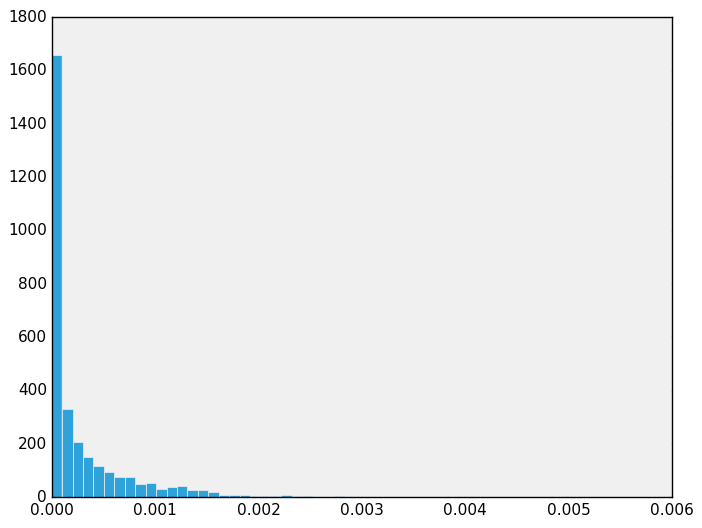

In [52]:
h=plt.hist(zip(*ll)[1], bins=50)

In [56]:
worst = int(np.where(np.array(ll)[:,1]==max(np.array(ll)[:,1]))[0])
worst

1512

In [59]:
ll[1512]

(1512, 0.0050517058948519487)

What does the worst log loss correspond to?

In [58]:
settings.classes[ilabels[worst]]

u'echinoderm_seacucumber_auricularia_larva'

In [64]:
misclass = int(np.where(y[worst,:121] == max(y[worst,:121]))[0])
misclass

35

It was misclassified as:

In [65]:
settings.classes[misclass]

u'detritus_other'

Looks like this:

Image.Image   (z)
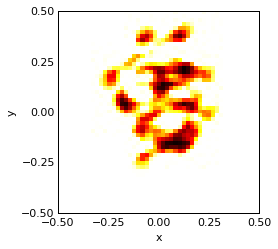

In [60]:
hl.Image(dataset.X[worst])

Image
      I     : Image.Image   (z)
      II    : Image.Image   (z)
      III   : Image.Image   (z)
      IV    : Image.Image   (z)
      V     : Image.Image   (z)
      VI    : Image.Image   (z)
      VII   : Image.Image   (z)
      VIII  : Image.Image   (z)
      IX    : Image.Image   (z)
      X     : Image.Image   (z)
      XI    : Image.Image   (z)
      XII   : Image.Image   (z)
      XIII  : Image.Image   (z)
      XIV   : Image.Image   (z)
      XV    : Image.Image   (z)
      XVI   : Image.Image   (z)
      XVII  : Image.Image   (z)
      XVIII : Image.Image   (z)
      XIX   : Image.Image   (z)
      XX    : Image.Image   (z)
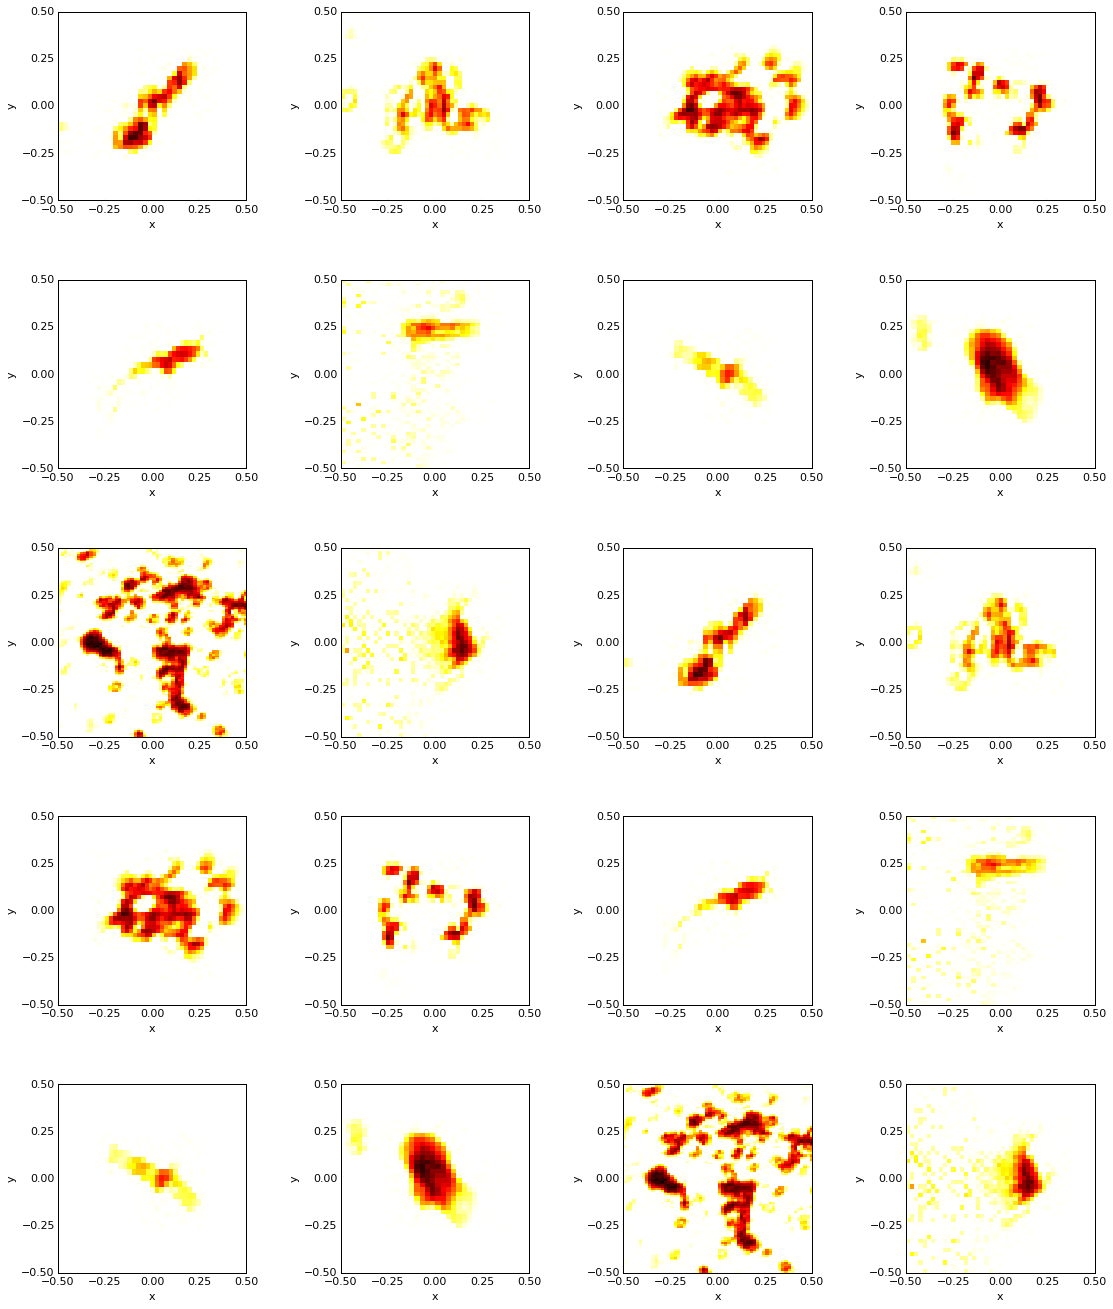

In [70]:
for d in np.where(ilabels == misclass)[0][:10]:
    try:
        c += hl.Image(dataset.X[d])
    except:
        c = hl.Image(dataset.X[d])
c

In [71]:
hier[2]

['calycophoran_siphonophores',
 'copepods',
 'crustaceans',
 'ctenophores',
 'cyclopoid_copepods',
 'echinoderm',
 'gastropods',
 'gelatinous zooplankton',
 'hydromedusae',
 'no_class',
 'other_invert_larvae',
 'pelagic_tunicates',
 'plankton',
 'protists',
 'shrimp_like',
 'siphonophores']

In [74]:
np.copyto(predictions, y)
y.shape

(3089, 188)

In [75]:
labels = labels[:, :121]
logloss = sklearn.metrics.log_loss(labels,predictions[:, :121])
print("Log loss: {0}".format(logloss))

Log loss: 0.935334935387


In [81]:
superclasses2 = predictions[:,(121+38):(121+38+16)]
superclasses2.shape

(3089, 16)

Get children of each second parent superclass.

In [42]:
superclass2_children = {}
settings = neukrill_net.utils.Settings("settings.json")
hier = enc.get_hierarchy(settings)

for s in hier[2]:
    children = []
    for key, values in t.superclasses.items():
        for i, v in enumerate(values):
            if s == v:
                if i > 0:
                    if values[i-1] not in children:
                        children.append(values[i-1])
    superclass2_children[s] = children

In [43]:
superclass2_children

{'calycophoran_siphonophores': ['rocketship',
  'sphaeronectes',
  'siphonophore_calycophoran_abylidae'],
 'copepods': ['calanoid', 'cyclopoid_copepods'],
 'crustaceans': ['shrimp_like',
  'copepods',
  'stomatopod',
  'amphipods',
  'crustacean_other'],
 'ctenophores': ['ctenophore_cestid', 'ctenophore_lobate', 'cydippid'],
 'cyclopoid_copepods': ['oithona', 'copepod_cyclopoid_copilia'],
 'echinoderm': ['seastar',
  'echinoderm_seacucumber_auricularia_larva',
  'pluteus'],
 'gastropods': ['pteropods', 'heteropod'],
 'gelatinous zooplankton': ['ctenophores',
  'pelagic_tunicates',
  'hydromedusae',
  'siphonophores',
  'ephyra',
  'jellies_tentacles'],
 'hydromedusae': ['other_hydromedusae',
  'sub_hydromedusae2',
  'sub_hydromedusae1'],
 'no_class': ['artifacts', 'artifacts_edge'],
 'other_invert_larvae': ['echinoderm',
  'tornaria_acorn_worm_larvae',
  'trochophore_larvae',
  'invertebrate_larvae_other_A',
  'invertebrate_larvae_other_B'],
 'pelagic_tunicates': ['appendicularians', '

In [72]:
nr = class_predictions
weight = 0.01
nr.shape

(3089, 121)

In [148]:
layer = t.TaxonomyLayer(1)
row = nr[1,:]
weight = 0.01

for key, value in superclass2_children.items():
    for i,v in enumerate(value):
        if v in only_leaf_children:
            update = {}
            for i, c in enumerate(settings.classes):
                if v == layer[c]:
                    print v
                    update[i] = settings.class_priors[i]
            denom = sum(v for k,v in update.items())
            indUpdate = [k for k,v in update.items()]
            print row[indUpdate]
            row[indUpdate] = row[indUpdate] * (1-weight) + [v for k,v in update.items()/denom * weight]
            print row[indUpdate]

acantharia
acantharia
acantharia
[  9.94898095e-01   8.29245158e-04   4.27219143e-03]
[  9.94085805e-01   9.54560106e-04   4.95917146e-03]
radiolarian
radiolarian
[ 0.03774202  0.02077784]
[ 0.04381403  0.02412063]
sub_protists
sub_protists
sub_protists
sub_protists
[ 0.00358086  0.01233393  0.03885892  0.0037466 ]
[ 0.00415695  0.01431824  0.04511056  0.00434936]
calanoid
calanoid
calanoid
calanoid
calanoid
calanoid
calanoid
calanoid
calanoid
calanoid
[ 0.02286404  0.00580834  0.00322312  0.00597621  0.00211518  0.00960222
  0.00355887  0.00164514  0.00292096  0.00080578]
[ 0.02654245  0.0067428   0.00374167  0.00693768  0.00245547  0.01114705
  0.00413142  0.00190981  0.00339089  0.00093542]
other_hydromedusae
other_hydromedusae
other_hydromedusae
other_hydromedusae
other_hydromedusae
other_hydromedusae
other_hydromedusae
other_hydromedusae
other_hydromedusae
other_hydromedusae
other_hydromedusae
other_hydromedusae
[ 0.00050232  0.00795334  0.01724619  0.01146956  0.00627895  0.00318

In [157]:
row == predictions[1,:121]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [62]:
only_leaf_children

['acantharia',
 'appendicularians',
 'calanoid',
 'chaetognaths',
 'cydippid',
 'decapods_all',
 'detritus',
 'diatoms',
 'euphausiids_all_ages',
 'fish',
 'no_class',
 'oithona',
 'other_hydromedusae',
 'physonect',
 'pluteus',
 'pteropods',
 'radiolarian',
 'rocketship',
 'seastar',
 'sphaeronectes',
 'sub_hydromedusae1',
 'sub_hydromedusae2',
 'sub_protists',
 'trichodesmium',
 'tunicate',
 'unknown']

In [88]:
settings.classes[97]

u'siphonophore_calycophoran_rocketship_adult'

In [65]:
layer['siphonophore_calycophoran_rocketship_adult']

'rocketship'